# Introduction

時系列データの不確実性を考慮した時系列予測を行います。


# 各種ライブラリの取得



In [1]:
%matplotlib inline 
import numpy as np
import pylab
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import sys
from matplotlib import animation as ani
import sklearn.metrics as mt
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, GRU, RepeatVector
from keras.layers.core import Dense, Lambda
from keras import objectives
from sklearn.preprocessing import MinMaxScaler
from copy import copy 
plt.style.use('ggplot')

/Users/masayaohgushi/.virtualenvs/time_series_anomaly_detect/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [2]:
wave_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])

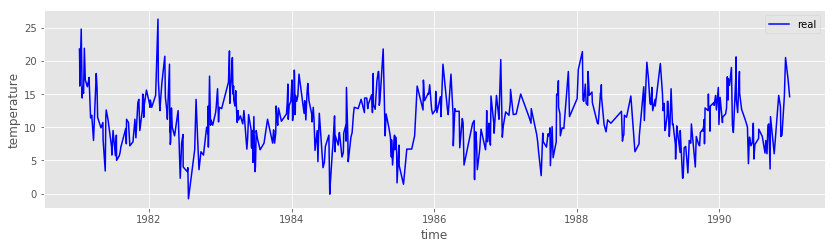

In [3]:
X_orig = wave_data["Temp"].values
X_day = wave_data["Date"].values

def show_graph(day, data, label, color="b"):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph(X_day, X_orig, 'real')

# データの分割

- 学習データ
- テストデータ

In [4]:
print(X_orig.shape)

X_train = X_orig[:400]
X_test = X_orig[400:]
X_train_day = X_day[:400]
X_test_day = X_day[400:]

(500,)


# 学習データ

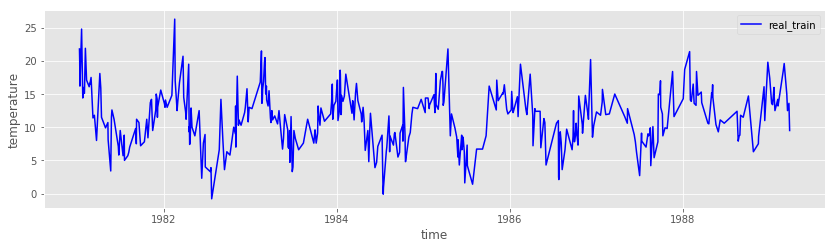

In [5]:
show_graph(X_train_day, X_train, 'real_train')

# テストデータ

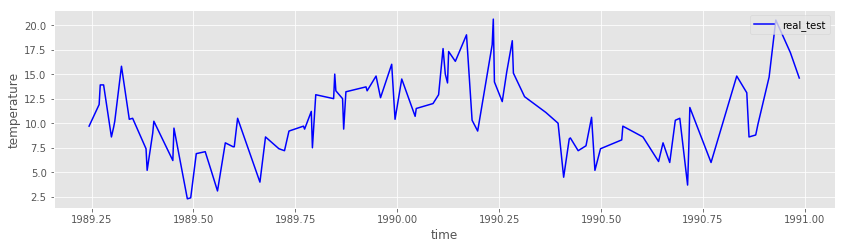

In [6]:
show_graph(X_test_day, X_test, 'real_test')

# 学習データのスムージング

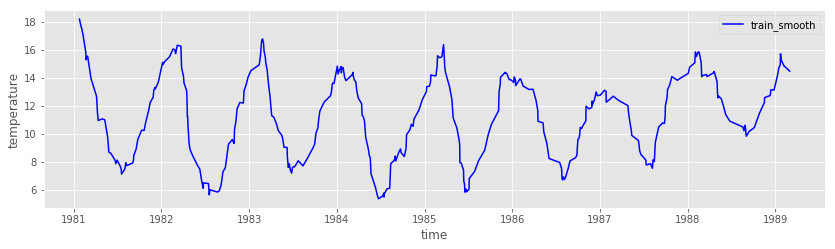

In [33]:
def smooth(x, window_len=11):

    w = np.ones(window_len, 'd')
    
    y = np.convolve( w / w.sum(), x, mode='valid')
    return y

half_window = 5
X_smooth_train = smooth(X_train)
X_train_day_smooth = X_train_day[half_window:-half_window]

show_graph(X_train_day_smooth, X_smooth_train, 'train_smooth')

# テストデータのスムージング

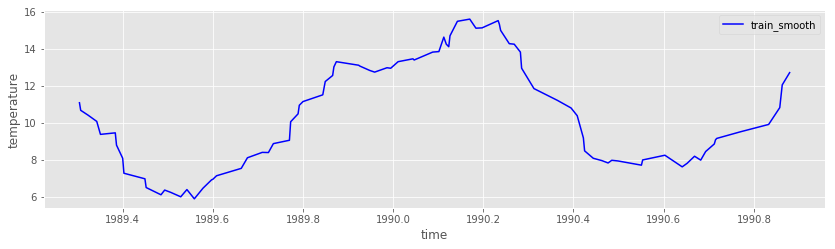

In [34]:
X_smooth_test = smooth(X_test)
X_test_day_smooth = X_test_day[half_window:-half_window]

show_graph(X_test_day_smooth, X_smooth_test, 'train_smooth')

# 前処理

- `get_data`: データを前処理して深層学習で扱える形に変換する
- `transform_data`: データを正規化して学習が容易な形に変更する。データを正規化後の値に戻して予測結果が適切か確認する

In [35]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    for i in range(len(data) - time_steps - 1):
        x = data[i:(i + time_steps), :]
        dataX.append(x)
    return np.array(dataX)

def transform_data(original_data: np.array, inverse_option: bool, scaler: object):
    data_shape = original_data.shape
    data = original_data.reshape(-1, 1)
    if inverse_option is True:
        print('before max {}'.format(max(data)))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data)))
    else:
        print('before max {}'.format(max(data)))
        print('Normalize')
        data = scaler.fit_transform(data)
        print(max(data))
        print('after max {}'.format(max(data)))
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler)
    data = np.asarray(data)
    data = data.reshape(-1, 1)
    x = get_data(data, time_steps=time_steps)
    return x, scaler

time_steps = 3

x, scaler = prepare_data(X_smooth_train, time_steps)

input_dim = x.shape[-1]
timesteps = x.shape[1]
print(x.shape)

before max [18.18181818]
Normalize
[1.]
after max [1.]
(390, 1)
(386, 3, 1)


# モデルの作成

- `create_model`でモデルを作成しています。指定できるのは
   - timestepsの幅
   - ノードの数
   - 自身の状態をリセットするかしないかを指定する`stateful`(周期的な波形は`True`の方が若干良くなります。)
   - `model_option`でGRUもしくはLSTMを選択できます。
   - `optimizer`で設定したい`optimizer`を指定できます。デファオルトでは`adam`が入っています。

In [36]:
def create_model(input_dim,
                 time_steps,
                 latent_dim,
                 # データが一つしかないので1しか選べない
                 batch_size=1,
                 model_option='lstm',
                 optimizer='adam',
                 drop_out=0.5,
                ):
    x = Input(shape=(time_steps, input_dim,))

    if model_option == 'lstm':
        h = LSTM(latent_dim, stateful=False, return_sequences=True, dropout=drop_out)(x)
    elif model_option == 'gru':
        h = GRU(latent_dim, stateful=False, return_sequences=True, dropout=drop_out)(x)

    out = Dense(input_dim)(h)

    model = Model(x, out)
    model.summary()

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# 予測関数

In [11]:
def predict_model_show_graph(day, x, scaler, model):
    prepare_value = x.copy()
    preds = model.predict(prepare_value)

    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, scaler=scaler)
    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, scaler=scaler)
    
    plt.figure(figsize=(14, 8))
    plt.plot(day, x_scale[:, 0, 0], color='r', label='data')
    plt.plot(day, predict_scale[:, 0, 0], color='b', label='predict')
    plt.legend()
    plt.show()
    return predict_scale, x_scale

# Dropoutにより不確実性を導出

ノイズが少ない分布を仮定

1,2,3,4%のノイズを付与

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_86 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_86 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 18ms/step - loss: 0.1759 - mean_squared_error: 0.1759
Epoch 2/200
386/386 [==============================] - 0s 196us/step - loss: 0.0729 - mean_squared_error: 0.0729
Epoch 3/200
386/386 [==============================] - 0s 200us/step - loss: 0.0552 - mean_squared_error: 0.0552
Epoch 4/200
386/386 [==============================] - 0s 200us/

386/386 [==============================] - 0s 242us/step - loss: 9.1074e-04 - mean_squared_error: 9.1074e-04
Epoch 67/200
386/386 [==============================] - 0s 216us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 68/200
386/386 [==============================] - 0s 204us/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 69/200
386/386 [==============================] - 0s 221us/step - loss: 0.0020 - mean_squared_error: 0.0020  
Epoch 70/200
386/386 [==============================] - 0s 233us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 71/200
386/386 [==============================] - 0s 215us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 72/200
386/386 [==============================] - 0s 209us/step - loss: 5.3831e-04 - mean_squared_error: 5.3831e-04
Epoch 73/200
386/386 [==============================] - 0s 205us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 74/200
386/386 [==============================] - 0s 205us/step - loss: 0.003

386/386 [==============================] - 0s 229us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 137/200
386/386 [==============================] - 0s 244us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 138/200
386/386 [==============================] - 0s 238us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 139/200
386/386 [==============================] - 0s 223us/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 140/200
386/386 [==============================] - 0s 217us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 141/200
386/386 [==============================] - 0s 215us/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 142/200
386/386 [==============================] - 0s 220us/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 143/200
386/386 [==============================] - 0s 220us/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 144/200
386/386 [==============================] - 0s 222us/step - loss: 0.0020 - mean_s

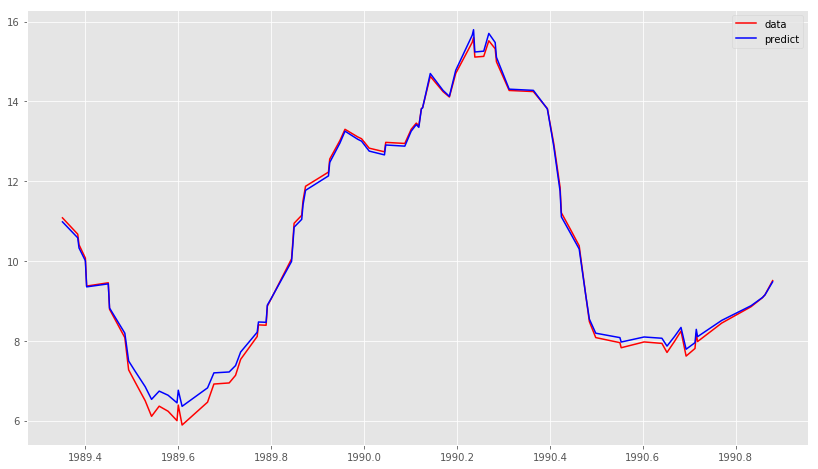

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_87 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 19ms/step - loss: 0.1953 - mean_squared_error: 0.1953
Epoch 2/200
386/386 [==============================] - 0s 201us/step - loss: 0.0837 - mean_squared_error: 0.0837
Epoch 3/200
386/386 [==============================] - 0s 210us/step - loss: 0.0591 - mean_squared_error: 0.0591
Epoch 4/200
386/386 [==============================] - 0s 218us/

386/386 [==============================] - 0s 215us/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 67/200
386/386 [==============================] - 0s 211us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 68/200
386/386 [==============================] - 0s 209us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 69/200
386/386 [==============================] - 0s 212us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 70/200
386/386 [==============================] - 0s 208us/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 71/200
386/386 [==============================] - 0s 208us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 72/200
386/386 [==============================] - 0s 211us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 73/200
386/386 [==============================] - 0s 215us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 74/200
386/386 [==============================] - 0s 221us/step - loss: 0.0050 - mean_squared_e

386/386 [==============================] - 0s 218us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 138/200
386/386 [==============================] - 0s 218us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 139/200
386/386 [==============================] - 0s 225us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 140/200
386/386 [==============================] - 0s 233us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 141/200
386/386 [==============================] - 0s 224us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 142/200
386/386 [==============================] - 0s 220us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 143/200
386/386 [==============================] - 0s 230us/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 144/200
386/386 [==============================] - 0s 229us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 145/200
386/386 [==============================] - 0s 232us/step - loss: 0.0026 - mean_s

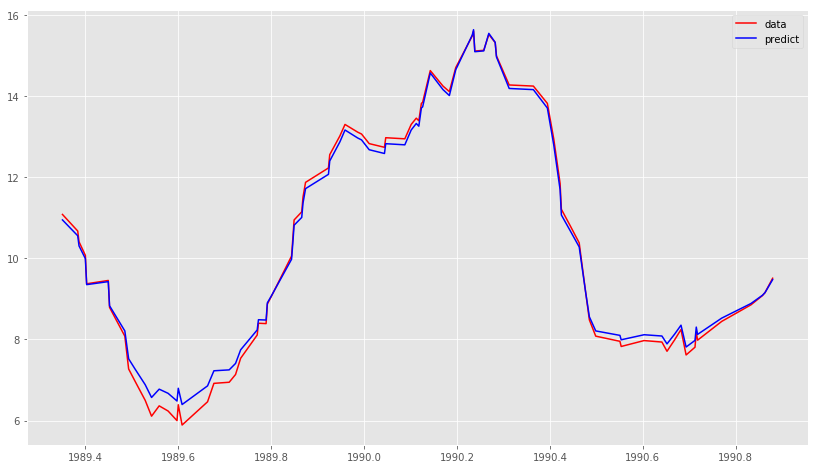

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_88 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_88 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 19ms/step - loss: 0.1871 - mean_squared_error: 0.1871
Epoch 2/200
386/386 [==============================] - 0s 199us/step - loss: 0.0785 - mean_squared_error: 0.0785
Epoch 3/200
386/386 [==============================] - 0s 202us/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 4/200
386/386 [==============================] - 0s 201us/

386/386 [==============================] - 0s 218us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 67/200
386/386 [==============================] - 0s 221us/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 68/200
386/386 [==============================] - 0s 225us/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 69/200
386/386 [==============================] - 0s 217us/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 70/200
386/386 [==============================] - 0s 219us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 71/200
386/386 [==============================] - 0s 226us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 72/200
386/386 [==============================] - 0s 223us/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 73/200
386/386 [==============================] - 0s 216us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 74/200
386/386 [==============================] - 0s 237us/step - loss: 0.0071 - mean_squared_e

386/386 [==============================] - 0s 212us/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 138/200
386/386 [==============================] - 0s 217us/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 139/200
386/386 [==============================] - 0s 212us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 140/200
386/386 [==============================] - 0s 216us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 141/200
386/386 [==============================] - 0s 230us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 142/200
386/386 [==============================] - 0s 246us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 143/200
386/386 [==============================] - 0s 234us/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 144/200
386/386 [==============================] - 0s 240us/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 145/200
386/386 [==============================] - 0s 229us/step - loss: 0.0027 - mean_s

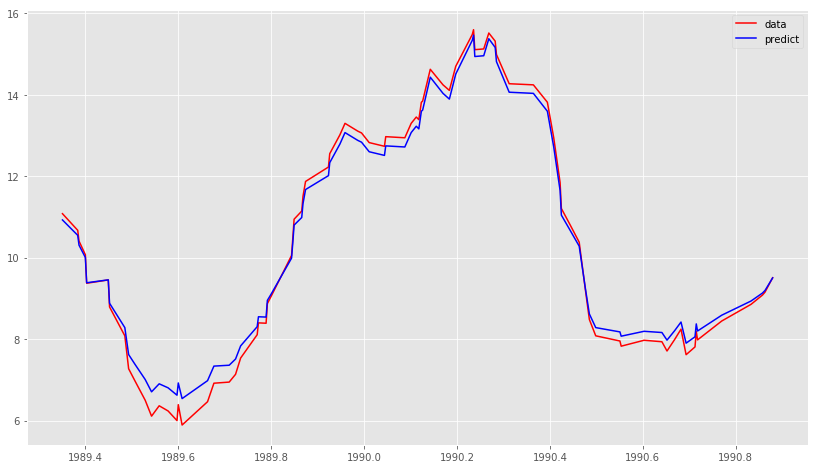

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_89 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_89 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 19ms/step - loss: 0.2141 - mean_squared_error: 0.2141
Epoch 2/200
386/386 [==============================] - 0s 206us/step - loss: 0.0902 - mean_squared_error: 0.0902
Epoch 3/200
386/386 [==============================] - 0s 202us/step - loss: 0.0671 - mean_squared_error: 0.0671
Epoch 4/200
386/386 [==============================] - 0s 206us/

386/386 [==============================] - 0s 223us/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 67/200
386/386 [==============================] - 0s 219us/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 68/200
386/386 [==============================] - 0s 234us/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 69/200
386/386 [==============================] - 0s 215us/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 70/200
386/386 [==============================] - 0s 222us/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 71/200
386/386 [==============================] - 0s 225us/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 72/200
386/386 [==============================] - 0s 217us/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 73/200
386/386 [==============================] - 0s 218us/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 74/200
386/386 [==============================] - 0s 213us/step - loss: 0.0074 - mean_squared_e

386/386 [==============================] - 0s 229us/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 138/200
386/386 [==============================] - 0s 223us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 139/200
386/386 [==============================] - 0s 222us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 140/200
386/386 [==============================] - 0s 222us/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 141/200
386/386 [==============================] - 0s 215us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 142/200
386/386 [==============================] - 0s 216us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 143/200
386/386 [==============================] - 0s 218us/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 144/200
386/386 [==============================] - 0s 216us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 145/200
386/386 [==============================] - 0s 217us/step - loss: 0.0047 - mean_s

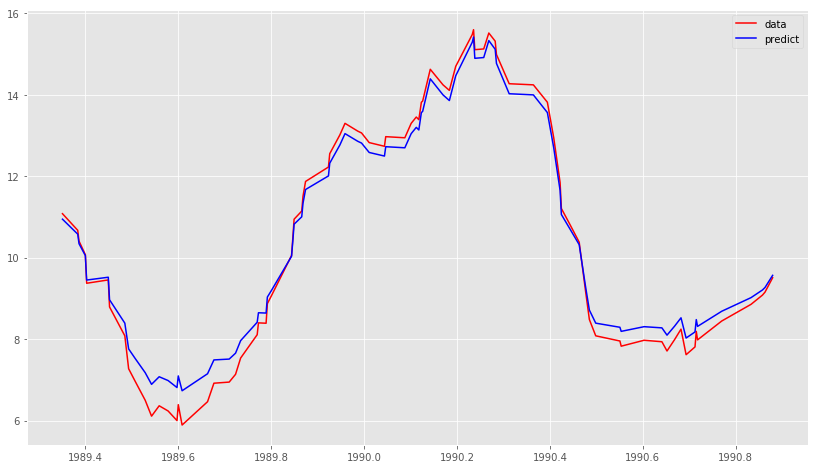

In [155]:
drop_out_list = [0.01, 0.02, 0.03, 0.04]
predict_list = []
var_list = []

for drop_out in drop_out_list:
    model = create_model(input_dim, 
                         time_steps=time_steps,
                         latent_dim=120,
                         model_option='lstm',
                         drop_out=drop_out,
                        )
    model.fit(x, x, epochs=200)
    window = time_steps
    x_test, scaler = prepare_data(X_smooth_test, time_steps)
    predict_test, x_scale_train = predict_model_show_graph(X_test_day_smooth[window + 1:], x_test, scaler, model)
    predict_list.append(predict_test)
    var_list.append(np.average(np.subtract(x_test, predict_test) ** 2))

# RMSEと分散を計算

In [156]:
average_predict = np.average(predict_list, axis=0)
average_predict = np.swapaxes(average_predict, 0, 1)[0]
average_predict = np.swapaxes(average_predict, 0, 1)[0]
rmse = np.sqrt(np.average(np.subtract(X_smooth_test[window + 1:], average_predict) ** 2))
variance = np.sqrt(np.average(var_list))
print('rmse:', rmse)
print('variance: ', variance)

rmse: 1.4165156764804878
variance:  10.179910667556284


In [157]:
noise_low_drop_out = [np.random.normal(y_p, variance) for y_p in average_predict]

# 予測の上限と下限のグラフを表示

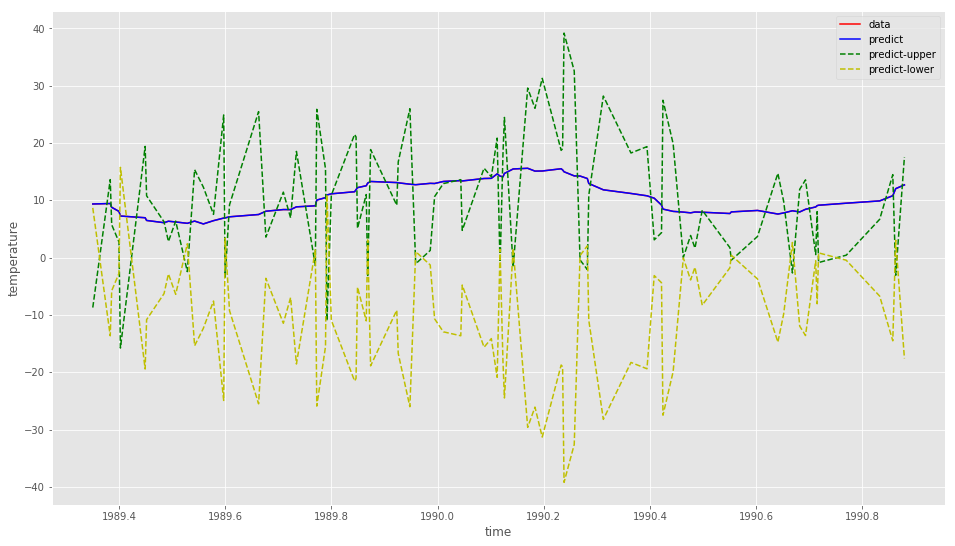

In [158]:
def show_three_graph(day, data, predict, predict_upper, predict_lower):
    pylab.figure(figsize=(16, 20))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, color='r', label='data')
    pylab.plot(day, data, color='b', label='predict')
    pylab.plot(day, predict_upper, color='g', linestyle='dashed', label='predict-upper')
    pylab.plot(day, predict_lower, color='y', linestyle='dashed', label='predict-lower')
    pylab.legend(loc='upper right')
    pylab.show()

show_three_graph(X_test_day_smooth[window + 1:], 
                 X_smooth_test[window + 1:], 
                 average_predict, 
                 noise_low_drop_out, 
                 -1 * np.array(noise_low_drop_out))

# Coverageを計算

In [159]:
X_test = X_smooth_test[window + 1:]
noise = np.array(noise_low_drop_out)
coverage_test = []

for i in range(X_test.shape[0]):
    if noise[i] > X_test[i]:  # noqa
        coverage_test.append(True)
    elif -1.0 * noise[i] < X_test[i]:  # noqa
        coverage_test.append(True)
    else:
        coverage_test.append(False)
        
print('Coverage:', sum(coverage_test) / len(coverage_test))

Coverage: 0.9767441860465116


# Dropoutにより不確実性を導出

ノイズが中程度の分布を仮定

10,20,30,40%のノイズを付与

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_82 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 18ms/step - loss: 0.2234 - mean_squared_error: 0.2234
Epoch 2/200
386/386 [==============================] - 0s 197us/step - loss: 0.1038 - mean_squared_error: 0.1038
Epoch 3/200
386/386 [==============================] - 0s 200us/step - loss: 0.0677 - mean_squared_error: 0.0677
Epoch 4/200
386/386 [==============================] - 0s 205us/

386/386 [==============================] - 0s 201us/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 67/200
386/386 [==============================] - 0s 202us/step - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 68/200
386/386 [==============================] - 0s 202us/step - loss: 0.0144 - mean_squared_error: 0.0144
Epoch 69/200
386/386 [==============================] - 0s 207us/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 70/200
386/386 [==============================] - 0s 205us/step - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 71/200
386/386 [==============================] - 0s 205us/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 72/200
386/386 [==============================] - 0s 224us/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 73/200
386/386 [==============================] - 0s 197us/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 74/200
386/386 [==============================] - 0s 198us/step - loss: 0.0131 - mean_squared_e

386/386 [==============================] - 0s 204us/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 138/200
386/386 [==============================] - 0s 208us/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 139/200
386/386 [==============================] - 0s 210us/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 140/200
386/386 [==============================] - 0s 209us/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 141/200
386/386 [==============================] - 0s 208us/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 142/200
386/386 [==============================] - 0s 206us/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 143/200
386/386 [==============================] - 0s 202us/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 144/200
386/386 [==============================] - 0s 199us/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 145/200
386/386 [==============================] - 0s 211us/step - loss: 0.0060 - mean_s

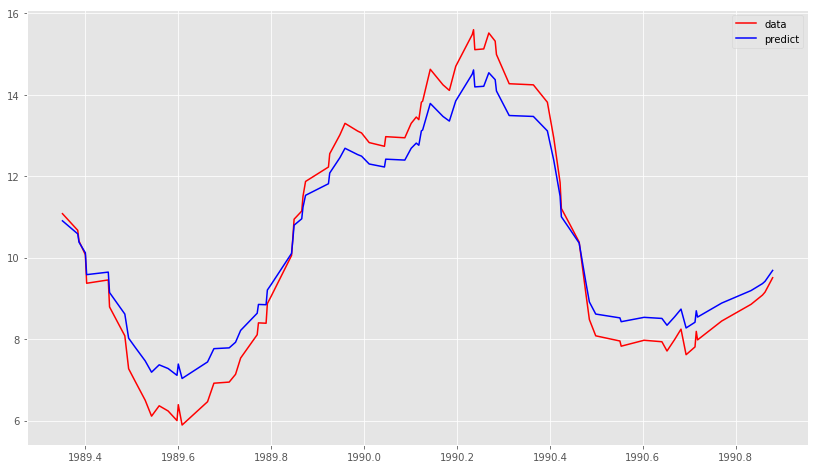

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_83 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_83 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 18ms/step - loss: 0.1998 - mean_squared_error: 0.1998
Epoch 2/200
386/386 [==============================] - 0s 198us/step - loss: 0.0945 - mean_squared_error: 0.0945
Epoch 3/200
386/386 [==============================] - 0s 205us/step - loss: 0.0769 - mean_squared_error: 0.0769
Epoch 4/200
386/386 [==============================] - 0s 211us/

386/386 [==============================] - 0s 197us/step - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 67/200
386/386 [==============================] - 0s 199us/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 68/200
386/386 [==============================] - 0s 203us/step - loss: 0.0156 - mean_squared_error: 0.0156
Epoch 69/200
386/386 [==============================] - 0s 195us/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 70/200
386/386 [==============================] - 0s 201us/step - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 71/200
386/386 [==============================] - 0s 201us/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 72/200
386/386 [==============================] - 0s 200us/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 73/200
386/386 [==============================] - 0s 205us/step - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 74/200
386/386 [==============================] - 0s 201us/step - loss: 0.0175 - mean_squared_e

386/386 [==============================] - 0s 219us/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 138/200
386/386 [==============================] - 0s 213us/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 139/200
386/386 [==============================] - 0s 200us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 140/200
386/386 [==============================] - 0s 197us/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 141/200
386/386 [==============================] - 0s 197us/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 142/200
386/386 [==============================] - 0s 208us/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 143/200
386/386 [==============================] - 0s 204us/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 144/200
386/386 [==============================] - 0s 199us/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 145/200
386/386 [==============================] - 0s 198us/step - loss: 0.0091 - mean_s

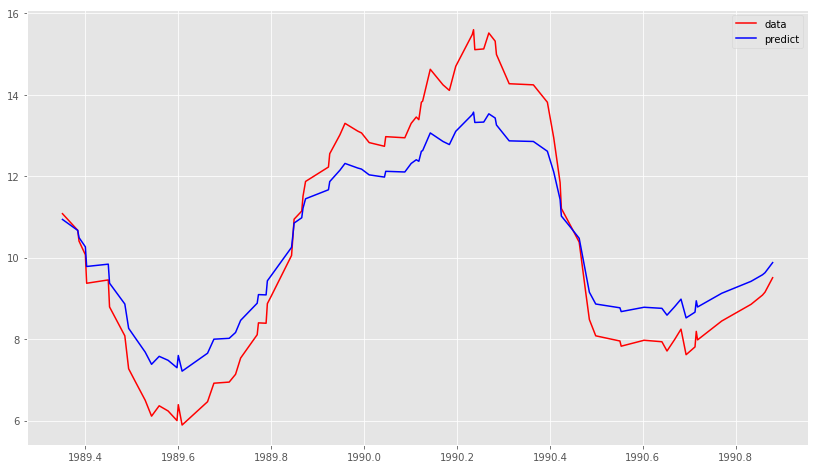

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_84 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 18ms/step - loss: 0.1995 - mean_squared_error: 0.1995
Epoch 2/200
386/386 [==============================] - 0s 206us/step - loss: 0.0933 - mean_squared_error: 0.0933
Epoch 3/200
386/386 [==============================] - 0s 199us/step - loss: 0.0828 - mean_squared_error: 0.0828
Epoch 4/200
386/386 [==============================] - 0s 199us/

386/386 [==============================] - 0s 213us/step - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 67/200
386/386 [==============================] - 0s 215us/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 68/200
386/386 [==============================] - 0s 203us/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 69/200
386/386 [==============================] - 0s 200us/step - loss: 0.0215 - mean_squared_error: 0.0215
Epoch 70/200
386/386 [==============================] - 0s 231us/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 71/200
386/386 [==============================] - 0s 222us/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 72/200
386/386 [==============================] - 0s 226us/step - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 73/200
386/386 [==============================] - 0s 232us/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 74/200
386/386 [==============================] - 0s 216us/step - loss: 0.0216 - mean_squared_e

386/386 [==============================] - 0s 221us/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 138/200
386/386 [==============================] - 0s 224us/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 139/200
386/386 [==============================] - 0s 214us/step - loss: 0.0152 - mean_squared_error: 0.0152
Epoch 140/200
386/386 [==============================] - 0s 216us/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 141/200
386/386 [==============================] - 0s 219us/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 142/200
386/386 [==============================] - 0s 233us/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 143/200
386/386 [==============================] - 0s 222us/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 144/200
386/386 [==============================] - 0s 234us/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 145/200
386/386 [==============================] - 0s 213us/step - loss: 0.0135 - mean_s

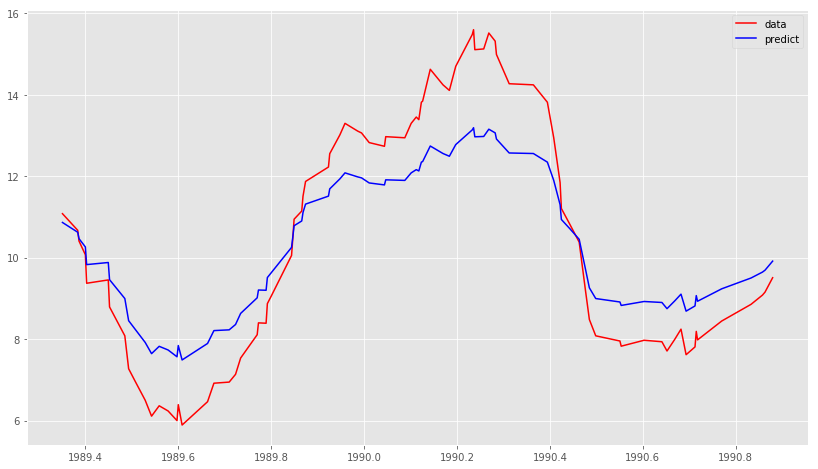

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_85 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 19ms/step - loss: 0.1901 - mean_squared_error: 0.1901
Epoch 2/200
386/386 [==============================] - 0s 243us/step - loss: 0.1054 - mean_squared_error: 0.1054
Epoch 3/200
386/386 [==============================] - 0s 188us/step - loss: 0.0882 - mean_squared_error: 0.0882
Epoch 4/200
386/386 [==============================] - 0s 206us/

386/386 [==============================] - 0s 230us/step - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 67/200
386/386 [==============================] - 0s 225us/step - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 68/200
386/386 [==============================] - 0s 222us/step - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 69/200
386/386 [==============================] - 0s 234us/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 70/200
386/386 [==============================] - 0s 233us/step - loss: 0.0241 - mean_squared_error: 0.0241
Epoch 71/200
386/386 [==============================] - 0s 234us/step - loss: 0.0222 - mean_squared_error: 0.0222
Epoch 72/200
386/386 [==============================] - 0s 259us/step - loss: 0.0242 - mean_squared_error: 0.0242
Epoch 73/200
386/386 [==============================] - 0s 239us/step - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 74/200
386/386 [==============================] - 0s 237us/step - loss: 0.0250 - mean_squared_e

386/386 [==============================] - 0s 231us/step - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 138/200
386/386 [==============================] - 0s 229us/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 139/200
386/386 [==============================] - 0s 235us/step - loss: 0.0215 - mean_squared_error: 0.0215
Epoch 140/200
386/386 [==============================] - 0s 219us/step - loss: 0.0239 - mean_squared_error: 0.0239
Epoch 141/200
386/386 [==============================] - 0s 222us/step - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 142/200
386/386 [==============================] - 0s 227us/step - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 143/200
386/386 [==============================] - 0s 217us/step - loss: 0.0196 - mean_squared_error: 0.0196
Epoch 144/200
386/386 [==============================] - 0s 218us/step - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 145/200
386/386 [==============================] - 0s 217us/step - loss: 0.0181 - mean_s

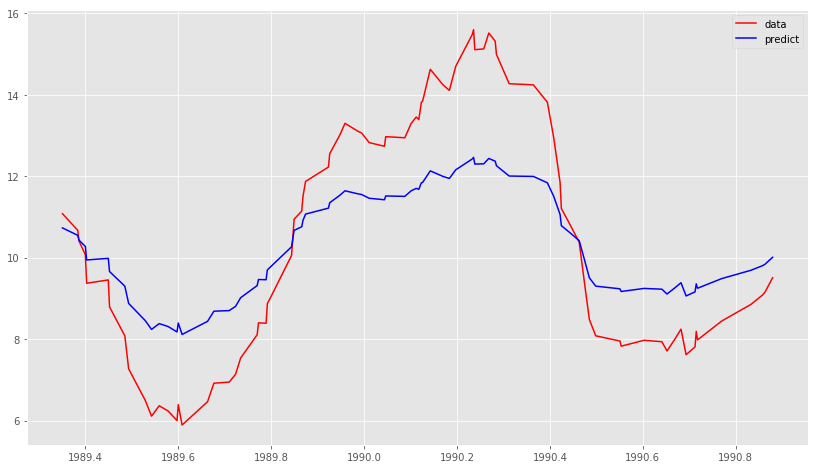

In [151]:
drop_out_list = [0.1, 0.2, 0.3, 0.4]
predict_list_middle = []
var_list_middle = []

for drop_out in drop_out_list:
    model = create_model(input_dim, 
                         time_steps=time_steps,
                         latent_dim=120,
                         model_option='lstm',
                         drop_out=drop_out,
                        )
    model.fit(x, x, epochs=200)
    window = time_steps
    x_test, scaler = prepare_data(X_smooth_test, time_steps)
    predict_test, x_scale_train = predict_model_show_graph(X_test_day_smooth[window + 1:], x_test, scaler, model)
    predict_list_middle.append(predict_test)
    var_list_middle.append(np.average(np.subtract(x_test, predict_test) ** 2))

# RMSEと分散を計算

In [152]:
average_predict = np.average(predict_list_middle, axis=0)
average_predict = np.swapaxes(average_predict, 0, 1)[0]
average_predict = np.swapaxes(average_predict, 0, 1)[0]
rmse = np.sqrt(np.average(np.subtract(X_smooth_test[window + 1:], average_predict) ** 2))
variance = np.sqrt(np.average(var_list_middle))
print('rmse:', rmse)
print('variance: ', variance)
noise_middle = [np.random.normal(y_p, variance) for y_p in average_predict]


rmse: 1.598764022260351
variance:  9.505208802429772


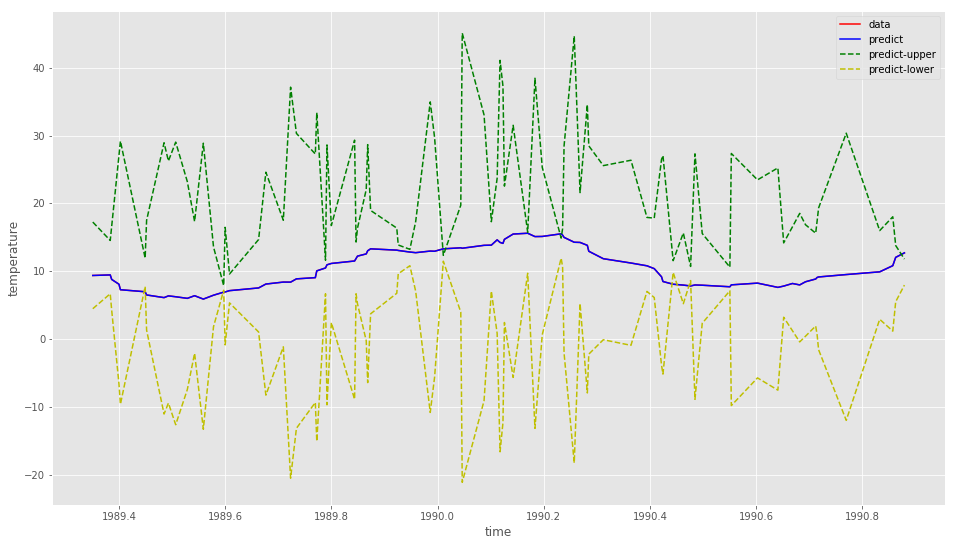

In [153]:
show_three_graph(X_test_day_smooth[window + 1:], 
                 X_smooth_test[window + 1:], 
                 average_predict, 
                 average_predict + np.abs(noise_middle), 
                 average_predict - np.abs(noise_middle))

# Coverageを計算

In [154]:
X_test = X_smooth_test[window + 1:]
noise = np.array(noise_middle)
coverage_test = []
print(noise.shape)

for i in range(X_test.shape[0]):
    if average_predict[i] + np.abs(noise[i]) > X_test[i] and average_predict[i] - np.abs(noise[i]) < X_test[i]:  # noqa
        coverage_test.append(True)
    else:
        coverage_test.append(False)
        
print(sum(coverage_test) / len(coverage_test))

(86,)
1.0


# Dropoutにより不確実性を導出

ノイズが多い分布を仮定

50,60,70,80%のノイズを付与

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_74 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 8s 20ms/step - loss: 0.1861 - mean_squared_error: 0.1861
Epoch 2/200
386/386 [==============================] - 0s 207us/step - loss: 0.1133 - mean_squared_error: 0.1133
Epoch 3/200
386/386 [==============================] - 0s 212us/step - loss: 0.0926 - mean_squared_error: 0.0926
Epoch 4/200
386/386 [==============================] - 0s 200us/

386/386 [==============================] - 0s 210us/step - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 67/200
386/386 [==============================] - 0s 205us/step - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 68/200
386/386 [==============================] - 0s 206us/step - loss: 0.0247 - mean_squared_error: 0.0247
Epoch 69/200
386/386 [==============================] - 0s 199us/step - loss: 0.0302 - mean_squared_error: 0.0302
Epoch 70/200
386/386 [==============================] - 0s 204us/step - loss: 0.0299 - mean_squared_error: 0.0299
Epoch 71/200
386/386 [==============================] - 0s 197us/step - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 72/200
386/386 [==============================] - 0s 208us/step - loss: 0.0259 - mean_squared_error: 0.0259
Epoch 73/200
386/386 [==============================] - 0s 194us/step - loss: 0.0261 - mean_squared_error: 0.0261
Epoch 74/200
386/386 [==============================] - 0s 197us/step - loss: 0.0310 - mean_squared_e

386/386 [==============================] - 0s 202us/step - loss: 0.0244 - mean_squared_error: 0.0244
Epoch 138/200
386/386 [==============================] - 0s 198us/step - loss: 0.0278 - mean_squared_error: 0.0278
Epoch 139/200
386/386 [==============================] - 0s 199us/step - loss: 0.0240 - mean_squared_error: 0.0240
Epoch 140/200
386/386 [==============================] - 0s 209us/step - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 141/200
386/386 [==============================] - 0s 199us/step - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 142/200
386/386 [==============================] - 0s 202us/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 143/200
386/386 [==============================] - 0s 209us/step - loss: 0.0222 - mean_squared_error: 0.0222
Epoch 144/200
386/386 [==============================] - 0s 201us/step - loss: 0.0247 - mean_squared_error: 0.0247
Epoch 145/200
386/386 [==============================] - 0s 205us/step - loss: 0.0255 - mean_s

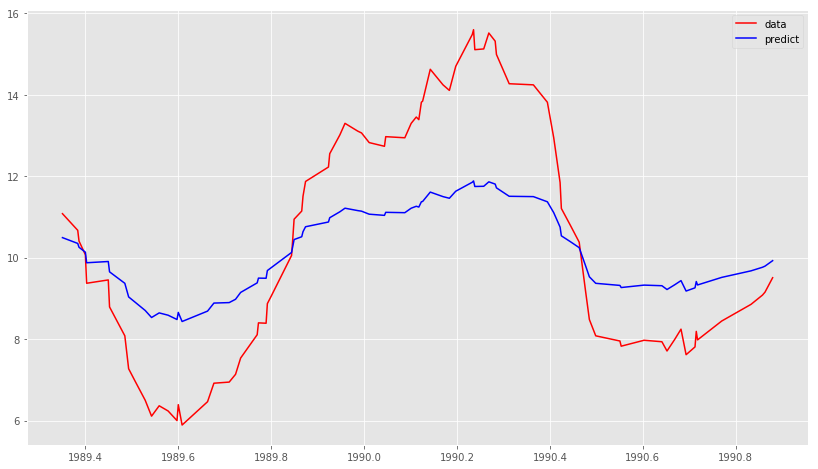

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_75 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_75 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 6s 16ms/step - loss: 0.2126 - mean_squared_error: 0.2126
Epoch 2/200
386/386 [==============================] - 0s 195us/step - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 3/200
386/386 [==============================] - 0s 202us/step - loss: 0.0994 - mean_squared_error: 0.0994
Epoch 4/200
386/386 [==============================] - 0s 204us/

386/386 [==============================] - 0s 210us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 67/200
386/386 [==============================] - 0s 209us/step - loss: 0.0311 - mean_squared_error: 0.0311
Epoch 68/200
386/386 [==============================] - 0s 207us/step - loss: 0.0307 - mean_squared_error: 0.0307
Epoch 69/200
386/386 [==============================] - 0s 206us/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 70/200
386/386 [==============================] - 0s 201us/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 71/200
386/386 [==============================] - 0s 229us/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 72/200
386/386 [==============================] - 0s 208us/step - loss: 0.0352 - mean_squared_error: 0.0352
Epoch 73/200
386/386 [==============================] - 0s 200us/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 74/200
386/386 [==============================] - 0s 203us/step - loss: 0.0311 - mean_squared_e

386/386 [==============================] - 0s 231us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 138/200
386/386 [==============================] - 0s 211us/step - loss: 0.0294 - mean_squared_error: 0.0294
Epoch 139/200
386/386 [==============================] - 0s 204us/step - loss: 0.0301 - mean_squared_error: 0.0301
Epoch 140/200
386/386 [==============================] - 0s 202us/step - loss: 0.0300 - mean_squared_error: 0.0300
Epoch 141/200
386/386 [==============================] - 0s 203us/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 142/200
386/386 [==============================] - 0s 195us/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 143/200
386/386 [==============================] - 0s 196us/step - loss: 0.0281 - mean_squared_error: 0.0281
Epoch 144/200
386/386 [==============================] - 0s 198us/step - loss: 0.0299 - mean_squared_error: 0.0299
Epoch 145/200
386/386 [==============================] - 0s 197us/step - loss: 0.0322 - mean_s

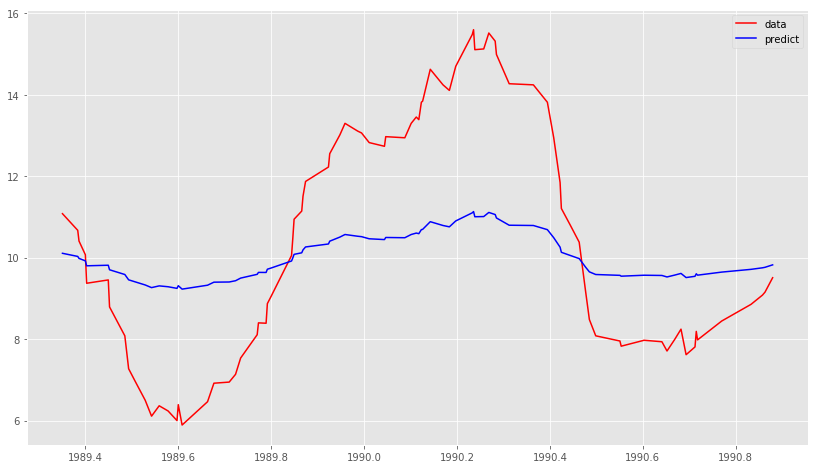

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_76 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 17ms/step - loss: 0.1949 - mean_squared_error: 0.1949
Epoch 2/200
386/386 [==============================] - 0s 210us/step - loss: 0.1272 - mean_squared_error: 0.1272
Epoch 3/200
386/386 [==============================] - 0s 214us/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 4/200
386/386 [==============================] - 0s 201us/

386/386 [==============================] - 0s 197us/step - loss: 0.0381 - mean_squared_error: 0.0381
Epoch 67/200
386/386 [==============================] - 0s 221us/step - loss: 0.0372 - mean_squared_error: 0.0372
Epoch 68/200
386/386 [==============================] - 0s 222us/step - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 69/200
386/386 [==============================] - 0s 208us/step - loss: 0.0366 - mean_squared_error: 0.0366
Epoch 70/200
386/386 [==============================] - 0s 222us/step - loss: 0.0350 - mean_squared_error: 0.0350
Epoch 71/200
386/386 [==============================] - 0s 233us/step - loss: 0.0371 - mean_squared_error: 0.0371
Epoch 72/200
386/386 [==============================] - 0s 205us/step - loss: 0.0380 - mean_squared_error: 0.0380
Epoch 73/200
386/386 [==============================] - 0s 204us/step - loss: 0.0390 - mean_squared_error: 0.0390
Epoch 74/200
386/386 [==============================] - 0s 213us/step - loss: 0.0395 - mean_squared_e

386/386 [==============================] - 0s 218us/step - loss: 0.0383 - mean_squared_error: 0.0383
Epoch 138/200
386/386 [==============================] - 0s 216us/step - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 139/200
386/386 [==============================] - 0s 208us/step - loss: 0.0361 - mean_squared_error: 0.0361
Epoch 140/200
386/386 [==============================] - 0s 200us/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 141/200
386/386 [==============================] - 0s 205us/step - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 142/200
386/386 [==============================] - 0s 198us/step - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 143/200
386/386 [==============================] - 0s 201us/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 144/200
386/386 [==============================] - 0s 200us/step - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 145/200
386/386 [==============================] - 0s 224us/step - loss: 0.0364 - mean_s

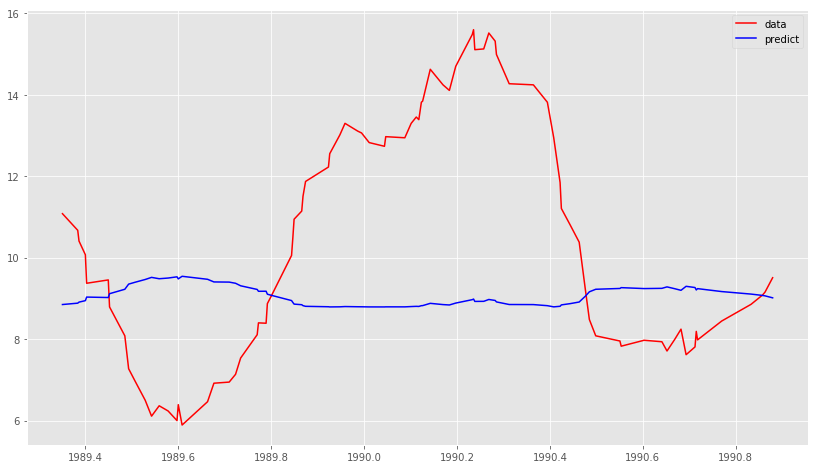

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_77 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 17ms/step - loss: 0.2139 - mean_squared_error: 0.2139
Epoch 2/200
386/386 [==============================] - 0s 211us/step - loss: 0.1432 - mean_squared_error: 0.1432
Epoch 3/200
386/386 [==============================] - 0s 208us/step - loss: 0.0951 - mean_squared_error: 0.0951
Epoch 4/200
386/386 [==============================] - 0s 215us/

386/386 [==============================] - 0s 226us/step - loss: 0.0423 - mean_squared_error: 0.0423
Epoch 67/200
386/386 [==============================] - 0s 209us/step - loss: 0.0422 - mean_squared_error: 0.0422
Epoch 68/200
386/386 [==============================] - 0s 203us/step - loss: 0.0431 - mean_squared_error: 0.0431
Epoch 69/200
386/386 [==============================] - 0s 204us/step - loss: 0.0463 - mean_squared_error: 0.0463
Epoch 70/200
386/386 [==============================] - 0s 203us/step - loss: 0.0440 - mean_squared_error: 0.0440
Epoch 71/200
386/386 [==============================] - 0s 203us/step - loss: 0.0420 - mean_squared_error: 0.0420
Epoch 72/200
386/386 [==============================] - 0s 219us/step - loss: 0.0443 - mean_squared_error: 0.0443
Epoch 73/200
386/386 [==============================] - 0s 214us/step - loss: 0.0446 - mean_squared_error: 0.0446
Epoch 74/200
386/386 [==============================] - 0s 219us/step - loss: 0.0418 - mean_squared_e

386/386 [==============================] - 0s 247us/step - loss: 0.0427 - mean_squared_error: 0.0427
Epoch 138/200
386/386 [==============================] - 0s 234us/step - loss: 0.0440 - mean_squared_error: 0.0440
Epoch 139/200
386/386 [==============================] - 0s 220us/step - loss: 0.0418 - mean_squared_error: 0.0418
Epoch 140/200
386/386 [==============================] - 0s 208us/step - loss: 0.0410 - mean_squared_error: 0.0410
Epoch 141/200
386/386 [==============================] - 0s 218us/step - loss: 0.0408 - mean_squared_error: 0.0408
Epoch 142/200
386/386 [==============================] - 0s 222us/step - loss: 0.0373 - mean_squared_error: 0.0373
Epoch 143/200
386/386 [==============================] - 0s 240us/step - loss: 0.0420 - mean_squared_error: 0.0420
Epoch 144/200
386/386 [==============================] - 0s 238us/step - loss: 0.0401 - mean_squared_error: 0.0401
Epoch 145/200
386/386 [==============================] - 0s 219us/step - loss: 0.0383 - mean_s

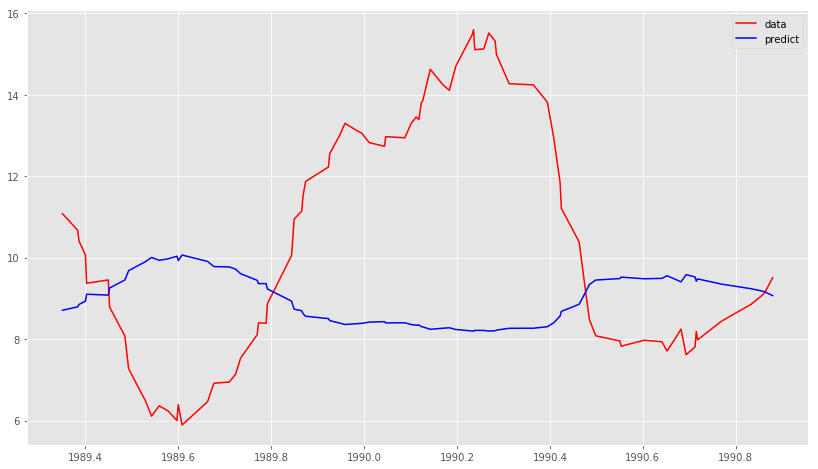

In [128]:
drop_out_list = [0.5, 0.6, 0.7, 0.8]
predict_list_high = []
var_list_high = []

for drop_out in drop_out_list:
    model = create_model(input_dim, 
                         time_steps=time_steps,
                         latent_dim=120,
                         model_option='lstm',
                         drop_out=drop_out,
                        )
    model.fit(x, x, epochs=200)
    window = time_steps
    x_test, scaler = prepare_data(X_smooth_test, time_steps)
    predict_test, x_scale_train = predict_model_show_graph(X_test_day_smooth[window + 1:], x_test, scaler, model)
    predict_list_high.append(predict_test)
    var_list_high.append(np.average(np.subtract(x_test, predict_test) ** 2))

# RMSEと分散を計算

In [147]:
average_predict = np.average(predict_list_high, axis=0)
average_predict = np.swapaxes(average_predict, 0, 1)[0]
average_predict = np.swapaxes(average_predict, 0, 1)[0]
rmse = np.sqrt(np.average(np.subtract(X_smooth_test[window + 1:], average_predict) ** 2))
variance = np.sqrt(np.average(var_list_high))
print('rmse:', rmse)
print('variance: ', variance)
noise_high_drop_out = [np.random.normal(y_p, variance) for y_p in average_predict]


rmse: 2.8866083856454576
variance:  8.150609387487762


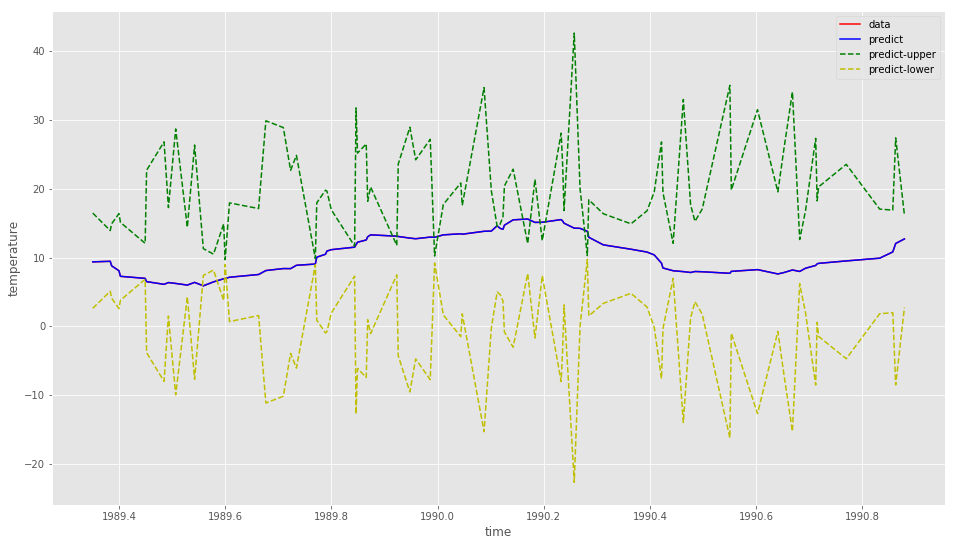

In [148]:
show_three_graph(X_test_day_smooth[window + 1:], 
                 X_smooth_test[window + 1:], 
                 average_predict, 
                 average_predict + np.abs(noise_high_drop_out), 
                 average_predict - np.abs(noise_high_drop_out))

# Coverageを計算

In [149]:
X_test = X_smooth_test[window + 1:]
noise = np.array(noise_high_drop_out)
coverage_test = []
print(noise.shape)

for i in range(X_test.shape[0]):
    if average_predict[i] + np.abs(noise[i]) > X_test[i] and average_predict[i] - np.abs(noise[i]) < X_test[i]:  # noqa
        coverage_test.append(True)
    else:
        coverage_test.append(False)
        
print(sum(coverage_test) / len(coverage_test))

(86,)
1.0
